In [3]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # pr'int content of ROOT (Optional)

drive.mount(ROOT)

/content/drive
Mounted at /content/drive


**SETTING UP DIRECTORIES**

In [4]:
MY_GOOGLE_DRIVE_PATH = 'My Drive/ADL_12202020/'
GIT_TOKEN = '418ef650c19648943e83f603b347b5da5012edc8'
GIT_USERNAME = 'AmoghM'
GIT_REPOSITORY = 'Hate-Toxicity-Detection'

from os.path import join  

PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

In [5]:
%cd "{PROJECT_PATH}"
%cd "Hate-Toxicity-Detection"

/content/drive/My Drive/ADL_12202020
/content/drive/My Drive/ADL_12202020/Hate-Toxicity-Detection


In [6]:
!pip install transformers

     |████████████████████████████████| 1.5MB 5.8MB/s 
     |████████████████████████████████| 890kB 44.9MB/s 
     |████████████████████████████████| 2.9MB 45.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=995ef414055b3d99ced4ded359cbd18fe891afd6d15be3ff172b6234724da37c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [7]:
!pip install torch --upgrade

     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


# **Project Background**

**Project Title** : Hate and Offensive content detection

**Introduction:**

The large fraction of hate speech and other offensive and objectionable content online poses a huge challenge to societies. Offensive language such as insulting, hurtful, derogatory or obscene content directed from one person to another person and open for others undermines objective discussions. Such type of language can be more increasingly found on the web and can lead to the radicalization of debates. Online communities, social media enterprises and technology companies have been investing heavily in technology and processes to identify offensive language in order to prevent abusive behavior in social media.

**DATA:**

Dataset will be created from the Twitter and Facebook and distributed in tab separated format. Participants are allowed to use external resources and other datasets for this task. Dataset will be prepared in 2 languages (English and code-mixed hindi).
The size of Training data corpus is approximately 8000 posts for each language.



**Tasks**
Our objective behind the HASOC shared task is to leverage the synergies of both forums. HASOC shared task is offered in 3 sub-tasks.


Participants in this year’s shared task can choose to participate in one, two or all of the subtasks.



**Sub-task A :-**
Sub-task A focus on Hate speech and Offensive language identification offered for English, German, Hindi. Sub-task A is coarse-grained binary classification in which participating system are required to classify tweets into two class, namely: Hate and Offensive (HOF) and Non- Hate and offensive (NOT).

**(NOT) Non Hate-Offensive **- This post does not contain any Hate speech, offensive content.

**(HOF) Hate and Offensive **- This post contains Hate, offensive, and profane content.

In our annotation, we label a post as HOF if it contains any form of non-acceptable language such as hate speech, aggression, profanity otherwise NOT.



**Sub-task B :-**

Sub-task B is a fine-grained classification. Hate-speech and offensive posts from the sub-task A are further classified into three categories.

**(HATE) Hate speech **:- Posts under this class contain Hate speech content.

**(OFFN) Offenive **:- Posts under this class contain offensive content.

**(PRFN) Profane **:- These posts contain profane words.

**HATE SPEECH**
Describing negative attributes or deficiencies to groups of individuals because they are members of a group (e.g. all poor people are stupid). Hateful comment toward groups because of race, political opinion, sexual orientation, gender, social status, health condition or similar.

**OFFENSIVE**
Posts which are degrading, dehumanizing,insulting an individual,threatening with violent acts are categorized into OFFENSIVE category.

**PROFANITY**
Unacceptable language in the absence of insults and abuse. This typically concerns the usage of swearwords (Scheiße, Fuck etc.) and cursing (Zur Hölle! Verdammt! etc.) are categorized into this category.

We expect most posts to be OTHER, some to be HATE and the other two categories to be less frequent. Dubious cases which are difficult to decide even for humans, should be left out.



**Sub-task C :-**
Sub-task c will check the type of offense. Only posts labeled as HOF in sub-task A are included in sub-task C. The two categories in sub-task C are the following:

**Targeted Insult (TIN):** Posts containing an insult/threat to an individual, group, or others.

**Untargeted (UNT):** Posts containing nontargeted profanity and swearing. Posts with general profanity are not targeted, but they contain non-acceptable language.

The multilingual HASOC Corpus will be sampled from Facebook and Twitter and distributed in tab separated format. Participants are allowed to use external resources and other datasets for this task. Dataset will be prepared in 2 languages (English and code-mixed hindi).

The size of Training data corpus is approximately 6000 posts for each language and Test data is approximately 1000 posts for the each language. Classification systems in all tasks will be evaluated using either macro-averaged F1-score or weighted F1-score.

**Imports**

In [8]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from collections import Counter
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AdamW, BertConfig, RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.pyplot import figure
from wordcloud import WordCloud, STOPWORDS 
import warnings
warnings.filterwarnings('ignore')


# **Exploratory Analysis of Data**

We start off by some analysis of the lengths of input sentences and their distributions, this would help us fix the maximum length of padded tokens for our transformer and LSTM based classifiers

We also plot a word cloud of the dataset to get and idea of the most commonly used in the dataset, as expected ,we find mainly offensive words and phrases in the cloud.

We also check the distribution of the classes and notice there is some skewness in the data for the task_2 and task_3, which ultimately impacts our accuracy metrics later on.

**English Dataset**

In [9]:
train_file_path = "data/english_dataset/english_dataset.tsv"
data = pd.read_csv(train_file_path, sep = '\t')

In [14]:
data['text_len'] = data.apply (lambda row: len(row['text'].split()), axis=1)

In [ ]:
data.head(10)

,text_id,text,task_1,task_2,task_3,text_len
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE,36
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF,HATE,TIN,17
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE,23
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE,11
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE,19
5,hasoc_en_6,@kellymiller513 @TheRealOJ32 I hope you rememb...,NOT,NONE,NONE,20
6,hasoc_en_7,@ICC Latest design of #WC2019 trophy. #CWC2019...,NOT,NONE,NONE,10
7,hasoc_en_8,#ADOS #trendingnow #blacklivesmatter #justice ...,HOF,PRFN,TIN,17
8,hasoc_en_9,Thanks for your support! Wow 600k. Graffiti ha...,NOT,NONE,NONE,26
9,hasoc_en_10,By wearing the #BalidaanBadge over his gloves ...,NOT,NONE,NONE,35


**Distribution of text length of training samples**

AxesSubplot(0.125,0.125;0.775x0.755)


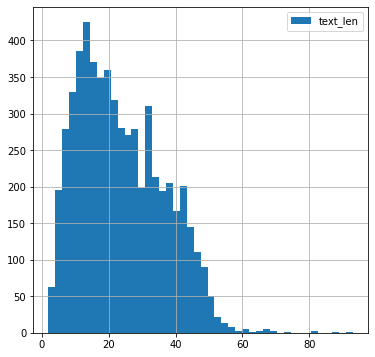

In [21]:
print(data['text_len'].hist(bins='auto', legend = True, figsize = (6,6)))

**Class-wise distribution of the training data**

For Task 1

AxesSubplot(0.125,0.125;0.775x0.755)


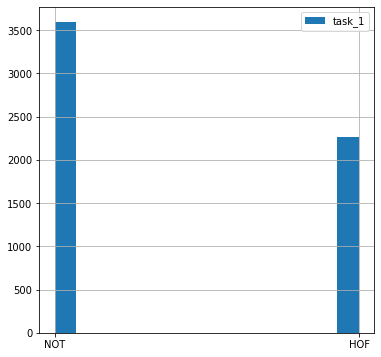

In [22]:
print(data['task_1'].hist(bins='auto', legend = True, figsize = (6,6)))

For Task 2

AxesSubplot(0.125,0.125;0.775x0.755)


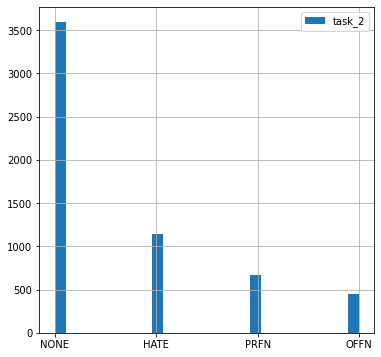

In [23]:
print(data['task_2'].hist(bins='auto', legend = True, figsize = (6,6)))

For Task 3

AxesSubplot(0.125,0.125;0.775x0.755)


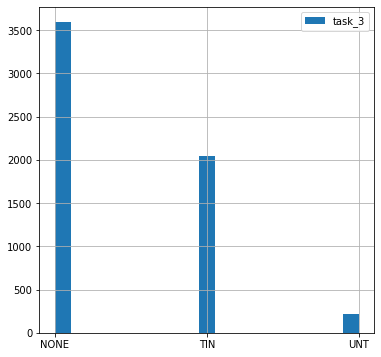

In [24]:
print(data['task_3'].hist(bins='auto', legend = True, figsize = (6,6)))

**Plotting a Word Cloud to get a better idea of our corpus**

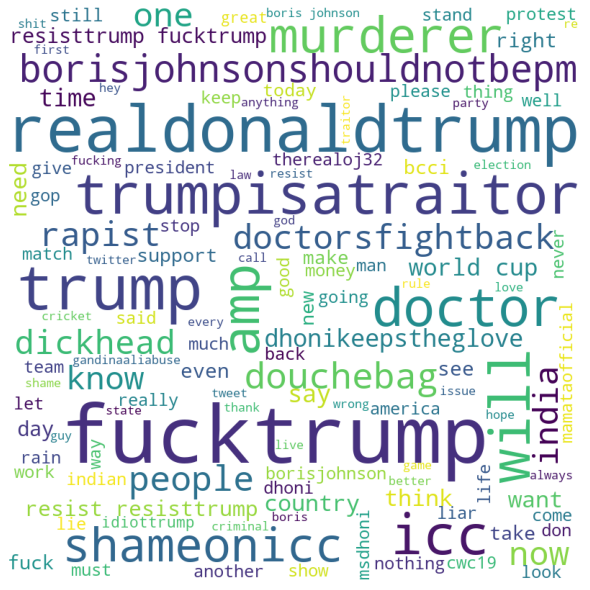

In [36]:
text_corpus = data['text']
comment_words = '' 
stopwords = set(STOPWORDS) 

## adding some custom stopwords
stopwords.add('http')
stopwords.add('https')
stopwords.add('co')

for val in text_corpus: 
    tokens = val.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    tokens = [ i for i in tokens if len(i) > 2]
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
  
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

**Hindi Dataset**

In [9]:
train_file_path = "data/hindi_dataset/hindi_dataset.tsv"
data = pd.read_csv(train_file_path, sep = '\t')

In [38]:
data['text_len'] = data.apply (lambda row: len(row['text'].split()), axis=1)

In [39]:
data.head(10)

,text_id,text,task_1,task_2,task_3,text_len
0,hasoc_hi_5556,"बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...",NOT,NONE,NONE,12
1,hasoc_hi_5648,सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...,HOF,PRFN,UNT,19
2,hasoc_hi_164,तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...,HOF,PRFN,TIN,58
3,hasoc_hi_3530,"बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...",NOT,NONE,NONE,23
4,hasoc_hi_5206,चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...,NOT,NONE,NONE,17
5,hasoc_hi_5121,मुंबई में बारिश से लोगों को काफी समस्या हो रही है,NOT,NONE,NONE,11
6,hasoc_hi_7142,Ahmed's dad:-- beta aaj teri mammy kyu nahi ba...,NOT,NONE,NONE,13
7,hasoc_hi_4321,"5 लाख मुसलमान उर्स में, अजमेर की दरगाह पर आते ...",NOT,NONE,NONE,43
8,hasoc_hi_4674,"Do mahashaktiyan mili hain, charo taraf khusi ...",NOT,NONE,NONE,28
9,hasoc_hi_1637,Chants of 'Jai Sri Ram' as Owaisi takes oath: ...,NOT,NONE,NONE,17


**Distribution of text length of training samples**

AxesSubplot(0.125,0.125;0.775x0.755)


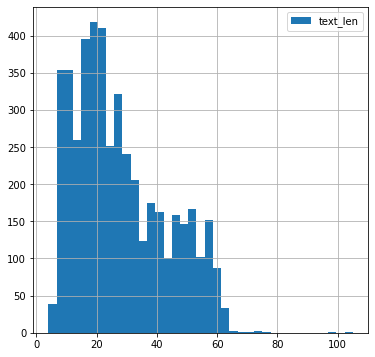

In [40]:
print(data['text_len'].hist(bins='auto', legend = True, figsize = (6,6)))

**Class-wise distribution of the training data**

For Task 1

AxesSubplot(0.125,0.125;0.775x0.755)


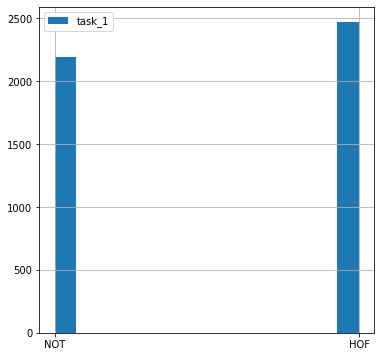

In [41]:
print(data['task_1'].hist(bins='auto', legend = True, figsize = (6,6)))

For Task 2

AxesSubplot(0.125,0.125;0.775x0.755)


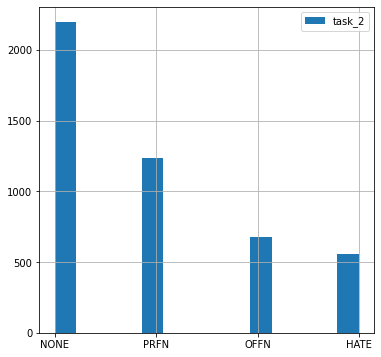

In [42]:
print(data['task_2'].hist(bins='auto', legend = True, figsize = (6,6)))

For Task 3

AxesSubplot(0.125,0.125;0.775x0.755)


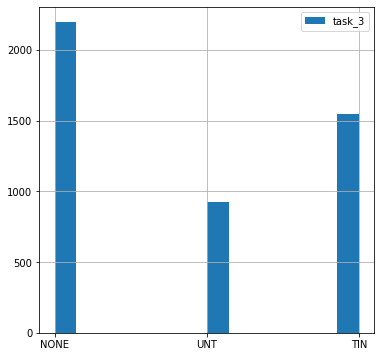

In [43]:
print(data['task_3'].hist(bins='auto', legend = True, figsize = (6,6)))

**Getting Dataset**

In [5]:
def get_dataset(mode = 'train', model_type = 'bert', class_map = None, max_inp_len = 100, file_path = None, task_type = None, batch_size = 8):
  """ Reads the csv file from data dir and returns a Tensor DataSet """
  data = pd.read_csv(file_path, sep="\t")

  if task_type == 'task_1':
    labels = list(class_map.keys())
    data = data[data['task_1'].isin(labels)]
    data['label'] = data.apply(lambda row: class_map[row['task_1']], axis=1)
  
  if task_type == 'task_2':
    labels = list(class_map.keys())
    data = data[data['task_2'].isin(labels)]
    data['label'] = data.apply(lambda row: class_map[row['task_2']], axis=1)
  
  if task_type == 'task_3':
      labels = list(class_map.keys())
      data = data[data['task_3'].isin(labels)]
      data['label'] = data.apply(lambda row: class_map[row['task_3']], axis=1)
  
  x = data['text'].values
  y = data['label'].values
  if model_type == 'roberta':
    tokenizer = AutoTokenizer.from_pretrained('roberta-base', do_lower_case = True)
  elif model_type == 'bert' or model_type == 'm-bert':
    tokenizer = AutoTokenizer.from_pretrained('model_artifacts/' + model_type + '', do_lower_case = True)
  input_ids = [tokenizer.encode(i, add_special_tokens = True) for i in x]
  input_ids = pad_sequences(input_ids, maxlen=max_inp_len, dtype="long", value=0, truncating="post", padding="post")
  labels = y

  attention_masks = [[int(token_id > 0) for token_id in x] for x in input_ids]
  
  if mode == "train":
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.25)
    train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.25)

    train_inputs = torch.tensor(train_inputs)
    validation_inputs = torch.tensor(validation_inputs)
    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)
    train_masks = torch.tensor(train_masks)
    validation_masks = torch.tensor(validation_masks)
    
    train_set = TensorDataset(train_inputs, train_masks, train_labels)
    validation_set = TensorDataset(validation_inputs, validation_masks, validation_labels)
    return train_set, validation_set
  else:
    test_inputs = torch.tensor(input_ids)
    test_masks = torch.tensor(attention_masks)
    test_labels = torch.tensor(labels)
    
    test_set = TensorDataset(test_inputs, test_masks, test_labels)
    return test_set


**Get GPU Device**

In [6]:
def get_device():
  if torch.cuda.is_available():    
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")
  return device

**Set Random Seed**

In [7]:
def set_random_seed(seed_val = 42):
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)


**Get Transformer Model**

In [8]:
def get_model(model_type = 'bert', num_classes = 2):
  """ takes transformer model type as input and returns pytorch model with Hugging Face checkpoint """
  if model_type == 'bert' or model_type == 'm-bert':
    model = BertForSequenceClassification.from_pretrained('model_artifacts/' + model_type + '/', num_labels = num_classes, \
                                                          output_attentions = False, output_hidden_states = False)
  elif model_type == 'roberta':
    model = RobertaForSequenceClassification.from_pretrained('model_artifacts/' + model_type + '/', num_labels = num_classes, \
                                                          output_attentions = False, output_hidden_states = False)
  
  return model 

**Get optimizer**

In [9]:
def get_optimizer(model, learning_rate = 5e-5, warmup_steps = 100, num_epochs = 4, total_steps = 100):
  """ takes model and optimizer params as input and returns optimizer and scheduler """
  optimizer = AdamW(model.parameters(), lr = learning_rate, eps = 1e-8)
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps,
                                          num_training_steps = total_steps)
  return (optimizer, scheduler)

**Get Accuracy Metrics**

In [10]:
import numpy as np
# Function to calculate the accuracy of our predictions vs labels
def get_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def update_conf_matrix(preds, labels, preds_arr, labels_arr):
  """ receives actual and predicted labels of a minibatch and returns the updated confusion matrix """
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  preds_arr = np.concatenate((preds_arr, pred_flat), axis = 0)
  labels_arr = np.concatenate((labels_arr, labels_flat), axis = 0)

  return (preds_arr, labels_arr)
  
def display_classification_report(y_pred, y_true, class_map):
  target_arr=[None] * len(class_map)
  for key in class_map.keys():
    target_arr[class_map[key]] = key

  print(classification_report(y_true, y_pred, target_names = target_arr))

def generate_loss_plot(x_val, y_vals):
  plt.figure(figsize=(10,10))

  for y_val in y_vals:
    plt.plot(x_val, y_val)
  plt.legend(['Validation loss','Training loss'])
  plt.xlabel("Num of Epochs")
  plt.ylabel("Loss function ")
  plt.title("Training and Validation Loss")
  plt.show()



**Validation Function**

In [11]:
def validate(model, validation_dataloader = None, num_classes  = 2, class_map = {}):
    print("Running Validation...")
    device = get_device()
    num_classes = len(list(class_map.keys()))
    conf_mat = torch.zeros(num_classes, num_classes)
    preds_arr = np.array([])
    labels_arr = np.array([])

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    eval_steps, eval_examples = 0, 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)    
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = get_accuracy(logits, label_ids)
        preds_arr, labels_arr = update_conf_matrix(logits, label_ids, preds_arr, labels_arr)

        
        eval_accuracy += tmp_eval_accuracy
        eval_loss += loss.item()
        eval_steps += 1
    print("  Accuracy: {0:.2f}".format(eval_accuracy/eval_steps))
    display_classification_report(preds_arr, labels_arr, class_map)
    eval_accuracy /= eval_steps
    eval_loss /= eval_steps
    return (eval_accuracy, eval_loss)


**Train Function**

In [12]:
def train(model = None, train_set = None, val_set = None, test_set = None, train_params = None, class_map = {}):
  num_classes = len(list(class_map.keys()))
  train_dataloader = DataLoader(train_set, batch_size = train_params['batch_size'], shuffle = True)
  val_dataloader = DataLoader(val_set, batch_size = train_params['batch_size'], shuffle = True)
  device = get_device()
  model = model.to(device)

  if test_set is not None:
    test_dataloader = DataLoader(test_set, batch_size = train_params['batch_size'], shuffle = True)
  
  total_steps = len(train_dataloader) * train_params['num_epochs']
  optimizer, scheduler = get_optimizer(model, learning_rate = train_params['learning_rate'], warmup_steps = train_params['warmup_steps'], \
                                       num_epochs = train_params['num_epochs'], total_steps = total_steps)
  
  curr_step = 0
  loss_values = []
  val_loss_values = []
  for epoch_i in range(0, train_params['num_epochs']):
    
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 100 == 0 and not step == 0:
          # print('Epoch = %d, step = %d'%(epoch_i, step))
          print(" For epoch = {0}, step = {1}, average training loss: {2:.3f}".format(epoch_i+1, step, total_loss/(step+1)))
          # val_accuracy, val_loss = validate(model, validation_dataloader = val_dataloader, num_classes= num_classes, class_map = class_map)
    

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        outputs = model(b_input_ids, token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)            
    
    loss_values.append(avg_train_loss)
    print("End of epoch  Average training loss: {0:.2f}".format(avg_train_loss))
    val_accuracy, val_loss = validate(model, validation_dataloader = val_dataloader, class_map = class_map)
    val_loss_values.append(val_loss)
    

  print("")
  print("Training complete!")
  generate_loss_plot(np.arange(train_params['num_epochs'])+1, [ val_loss_values, loss_values])

  print("Evaluating on test set")
  validate(model, validation_dataloader = test_dataloader, num_classes = num_classes, class_map = class_map)
  

  


# **Methodology**

**BERT Model :**
We use the BERT based uncased model as a text classifier, BERT model's CLS token is passed through a weight matrix and the softmax output is used a classifier.

WE load our BERT model from the Hugging Face checkpoint and finetune the weights on our dataset. We treat the problem as a multiclass classification problem and report our accuracy metrics for task_1, task_2 and task_3 below.

We had explored tuning some of the hyper parameters such as batch size, learning rate and input length, and have currently used the set of hyper params which Colab GPU is capable of running without crashing.

**DEFINING CONFIG PARAMS**

In [19]:
task_1_map = {'NOT' : 0, 'HOF' : 1}
task_2_map = {'HATE': 0, 'NONE': 1, 'OFFN': 2, 'PRFN': 3}
task_3_map = {'NONE': 0, 'TIN': 1, 'UNT': 2}

train_params = { 'batch_size' : 8, 'num_epochs' : 4, 'learning_rate' : 2e-5, 'warmup_steps' : 50, 'max_inp_len' : 100}

**FOR TASK 1: FETCHING DATASETS, RUNNING TRAIN AND VALIDATION**

Some weights of the model checkpoint at model_artifacts/bert/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoin

 For epoch = 1, step = 100, average training loss: 0.665
 For epoch = 1, step = 200, average training loss: 0.654
 For epoch = 1, step = 300, average training loss: 0.643
 For epoch = 1, step = 400, average training loss: 0.639
 For epoch = 1, step = 500, average training loss: 0.631
End of epoch  Average training loss: 0.63
Running Validation...
  Accuracy: 0.69
              precision    recall  f1-score   support

         NOT       0.70      0.87      0.77       903
         HOF       0.65      0.38      0.48       560

    accuracy                           0.69      1463
   macro avg       0.67      0.63      0.63      1463
weighted avg       0.68      0.69      0.66      1463

 For epoch = 2, step = 100, average training loss: 0.543
 For epoch = 2, step = 200, average training loss: 0.536
 For epoch = 2, step = 300, average training loss: 0.536
 For epoch = 2, step = 400, average training loss: 0.536
 For epoch = 2, step = 500, average training loss: 0.526
End of epoch  Average 

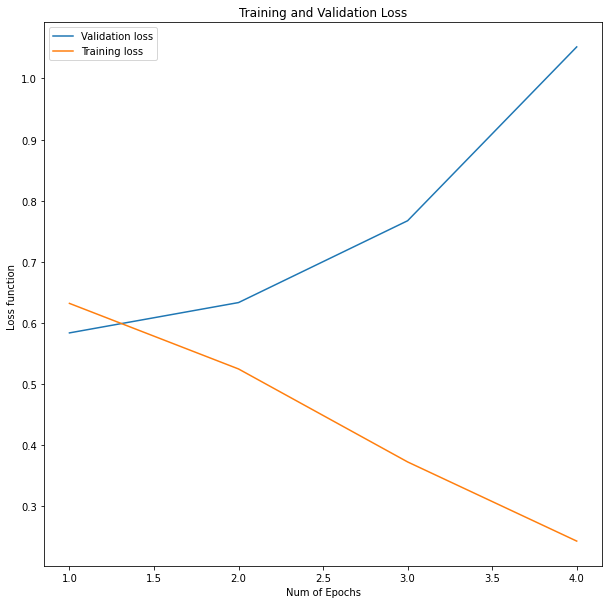

Evaluating on test set
Running Validation...
  Accuracy: 0.77
              precision    recall  f1-score   support

         NOT       0.91      0.77      0.84       865
         HOF       0.53      0.76      0.63       288

    accuracy                           0.77      1153
   macro avg       0.72      0.77      0.73      1153
weighted avg       0.81      0.77      0.78      1153



In [ ]:
class_map = task_1_map
task_type = 'task_1'
train_file_path = "data/english_dataset/english_dataset.tsv"
test_file_path = "data/english_dataset/hasoc2019_en_test-2919.tsv"


set_random_seed(seed_val = 42)

train_set, val_set = get_dataset(mode = 'train', model_type = 'bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = train_file_path, task_type = task_type, batch_size = train_params['batch_size'])

test_set = get_dataset(mode = 'test', model_type = 'bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = test_file_path, task_type = task_type, batch_size = train_params['batch_size'])

model = get_model(model_type = 'bert', num_classes = len(list(class_map.keys())))

train(model = model, train_set = train_set, val_set = val_set, test_set = test_set, train_params = train_params, class_map = class_map)

**FOR TASK 2: FETCHING DATASETS, RUNNING TRAIN AND VALIDATION**

Some weights of the model checkpoint at model_artifacts/bert/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoin

 For epoch = 1, step = 100, average training loss: 1.104
 For epoch = 1, step = 200, average training loss: 1.089
 For epoch = 1, step = 300, average training loss: 1.061
 For epoch = 1, step = 400, average training loss: 1.030
 For epoch = 1, step = 500, average training loss: 1.010
End of epoch  Average training loss: 1.00
Running Validation...
  Accuracy: 0.65
              precision    recall  f1-score   support

        HATE       0.00      0.00      0.00       286
        NONE       0.66      0.97      0.78       903
        OFFN       0.00      0.00      0.00       111
        PRFN       0.64      0.48      0.55       163

    accuracy                           0.65      1463
   macro avg       0.32      0.36      0.33      1463
weighted avg       0.48      0.65      0.54      1463



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 For epoch = 2, step = 100, average training loss: 0.823
 For epoch = 2, step = 200, average training loss: 0.859
 For epoch = 2, step = 300, average training loss: 0.864
 For epoch = 2, step = 400, average training loss: 0.851
 For epoch = 2, step = 500, average training loss: 0.843
End of epoch  Average training loss: 0.84
Running Validation...
  Accuracy: 0.65
              precision    recall  f1-score   support

        HATE       0.35      0.10      0.16       286
        NONE       0.70      0.91      0.79       903
        OFFN       0.33      0.17      0.22       111
        PRFN       0.58      0.51      0.54       163

    accuracy                           0.65      1463
   macro avg       0.49      0.42      0.43      1463
weighted avg       0.59      0.65      0.59      1463

 For epoch = 3, step = 100, average training loss: 0.710
 For epoch = 3, step = 200, average training loss: 0.702
 For epoch = 3, step = 300, average training loss: 0.711
 For epoch = 3, step = 400, 

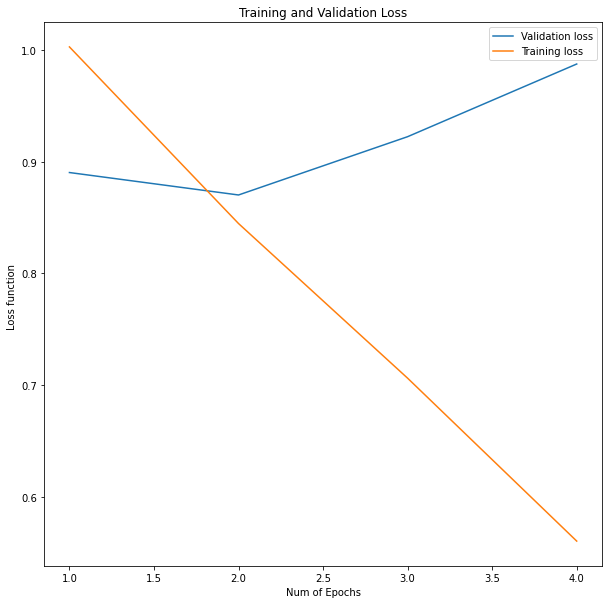

Evaluating on test set
Running Validation...
  Accuracy: 0.72
              precision    recall  f1-score   support

        HATE       0.27      0.61      0.37       124
        NONE       0.91      0.77      0.83       865
        OFFN       0.35      0.11      0.17        71
        PRFN       0.66      0.83      0.74        93

    accuracy                           0.71      1153
   macro avg       0.55      0.58      0.53      1153
weighted avg       0.79      0.71      0.73      1153



In [ ]:
class_map = task_2_map
task_type = 'task_2'
train_file_path = "data/english_dataset/english_dataset.tsv"
test_file_path = "data/english_dataset/hasoc2019_en_test-2919.tsv"


set_random_seed(seed_val = 42)

train_set, val_set = get_dataset(mode = 'train', model_type = 'bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = train_file_path, task_type = task_type, batch_size = train_params['batch_size'])

test_set = get_dataset(mode = 'test', model_type = 'bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = test_file_path, task_type = task_type, batch_size = train_params['batch_size'])

model = get_model(model_type = 'bert', num_classes = len(list(class_map.keys())))

train(model = model, train_set = train_set, val_set = val_set, test_set = test_set, train_params = train_params, class_map = class_map)

**FOR TASK 3: FETCHING DATASETS, RUNNING TRAIN AND VALIDATION**

Some weights of the model checkpoint at model_artifacts/bert/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoin

 For epoch = 1, step = 100, average training loss: 0.904
 For epoch = 1, step = 200, average training loss: 0.851
 For epoch = 1, step = 300, average training loss: 0.818
 For epoch = 1, step = 400, average training loss: 0.796
 For epoch = 1, step = 500, average training loss: 0.787
End of epoch  Average training loss: 0.78
Running Validation...
  Accuracy: 0.68
              precision    recall  f1-score   support

        NONE       0.69      0.94      0.79       903
         TIN       0.67      0.31      0.42       503
         UNT       0.00      0.00      0.00        57

    accuracy                           0.68      1463
   macro avg       0.45      0.42      0.41      1463
weighted avg       0.65      0.68      0.63      1463



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 For epoch = 2, step = 100, average training loss: 0.660
 For epoch = 2, step = 200, average training loss: 0.650
 For epoch = 2, step = 300, average training loss: 0.640
 For epoch = 2, step = 400, average training loss: 0.642
 For epoch = 2, step = 500, average training loss: 0.647
End of epoch  Average training loss: 0.65
Running Validation...
  Accuracy: 0.68
              precision    recall  f1-score   support

        NONE       0.72      0.84      0.78       903
         TIN       0.61      0.47      0.53       503
         UNT       0.12      0.04      0.05        57

    accuracy                           0.68      1463
   macro avg       0.48      0.45      0.45      1463
weighted avg       0.66      0.68      0.66      1463

 For epoch = 3, step = 100, average training loss: 0.536
 For epoch = 3, step = 200, average training loss: 0.501
 For epoch = 3, step = 300, average training loss: 0.511
 For epoch = 3, step = 400, average training loss: 0.504
 For epoch = 3, step = 50

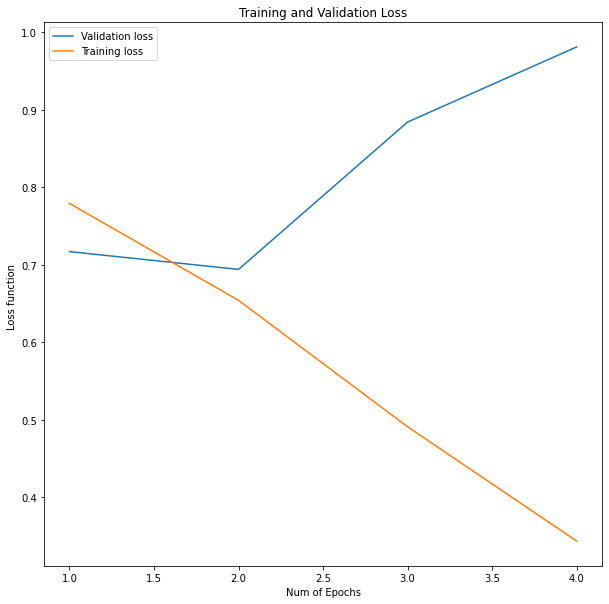

Evaluating on test set
Running Validation...
  Accuracy: 0.74
              precision    recall  f1-score   support

        NONE       0.90      0.80      0.85       865
         TIN       0.48      0.65      0.55       245
         UNT       0.04      0.05      0.04        43

    accuracy                           0.74      1153
   macro avg       0.47      0.50      0.48      1153
weighted avg       0.78      0.74      0.75      1153



In [ ]:
class_map = task_3_map
task_type = 'task_3'
train_file_path = "data/english_dataset/english_dataset.tsv"
test_file_path = "data/english_dataset/hasoc2019_en_test-2919.tsv"


set_random_seed(seed_val = 42)

train_set, val_set = get_dataset(mode = 'train', model_type = 'bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = train_file_path, task_type = task_type, batch_size = train_params['batch_size'])

test_set = get_dataset(mode = 'test', model_type = 'bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = test_file_path, task_type = task_type, batch_size = train_params['batch_size'])

model = get_model(model_type = 'bert', num_classes = len(list(class_map.keys())))

train(model = model, train_set = train_set, val_set = val_set, test_set = test_set, train_params = train_params, class_map = class_map)

**Discussions on the BERT Model**

We notice an test accuracy of 0.77 for task_1, 0.72 for task_2, and 0.74 for task_3.

For task_1, we can see that the model is a bit biased towards predicting not offensive.

For task_2, the overall accuracy drops to around 0.72 , this is mainly due to lower performance on the HATE and OFFENSIVE classes (which we can see from the class-wise F1 scores). Earlier we saw that these classes have low number of training samples. Adding more samples, could help boost the metrics of these two classes, thereby improving the overall accuracy.

For task_2, the overall accuracy is around 0.74, the F1 score for untargeted comments is low, whis is probably due lowe training samples for the untargeted class.




# **RoBERTa MODEL**

We also use the **Roberta-base** model to perform the task-wise classification.

The Roberta model has performed consistently well on public NLP leaderboards. It used a Byte-Pair Encoding Tokenizer, trains with larger minibatches and longer pretraining as well as dynamic masking of tokens per batch.

**CONFIG PARAMS**

In [31]:
task_1_map = {'NOT' : 0, 'HOF' : 1}
task_2_map = {'HATE': 0, 'NONE': 1, 'OFFN': 2, 'PRFN': 3}
task_3_map = {'NONE': 0, 'TIN': 1, 'UNT': 2}

train_params = { 'batch_size' : 8, 'num_epochs' : 4, 'learning_rate' : 2e-5, 'warmup_steps' : 50, 'max_inp_len' : 100}

**FOR TASK 1: FETCHING DATASETS, RUNNING TRAIN AND VALIDATION**

 For epoch = 1, step = 100, average training loss: 0.685
 For epoch = 1, step = 200, average training loss: 0.690
 For epoch = 1, step = 300, average training loss: 0.684
 For epoch = 1, step = 400, average training loss: 0.685
 For epoch = 1, step = 500, average training loss: 0.684
End of epoch  Average training loss: 0.69
Running Validation...
  Accuracy: 0.62
              precision    recall  f1-score   support

         NOT       0.62      1.00      0.76       903
         HOF       0.00      0.00      0.00       560

    accuracy                           0.62      1463
   macro avg       0.31      0.50      0.38      1463
weighted avg       0.38      0.62      0.47      1463

 For epoch = 2, step = 100, average training loss: 0.668
 For epoch = 2, step = 200, average training loss: 0.677
 For epoch = 2, step = 300, average training loss: 0.679
 For epoch = 2, step = 400, average training loss: 0.680
 For epoch = 2, step = 500, average training loss: 0.683
End of epoch  Average 

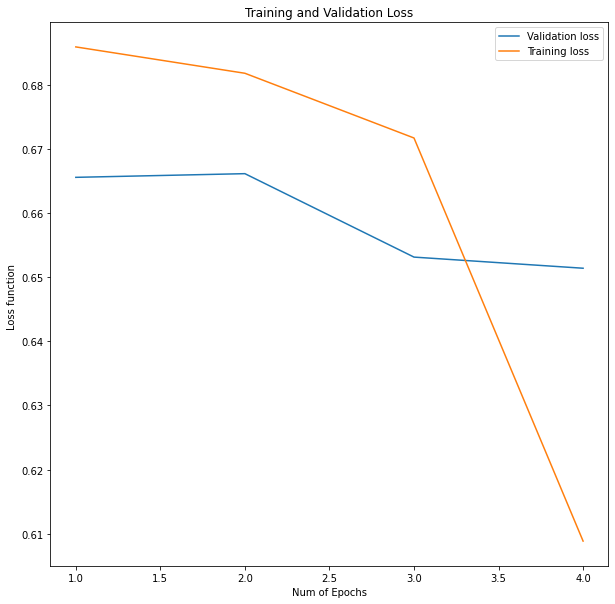

Evaluating on test set
Running Validation...
  Accuracy: 0.69
              precision    recall  f1-score   support

         NOT       0.81      0.78      0.79       865
         HOF       0.40      0.44      0.42       288

    accuracy                           0.69      1153
   macro avg       0.60      0.61      0.60      1153
weighted avg       0.70      0.69      0.70      1153



In [32]:
class_map = task_1_map
task_type = 'task_1'
train_file_path = "data/english_dataset/english_dataset.tsv"
test_file_path = "data/english_dataset/hasoc2019_en_test-2919.tsv"


set_random_seed(seed_val = 42)

train_set, val_set = get_dataset(mode = 'train', model_type = 'roberta', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = train_file_path, task_type = task_type, batch_size = train_params['batch_size'])

test_set = get_dataset(mode = 'test', model_type = 'roberta', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = test_file_path, task_type = task_type, batch_size = train_params['batch_size'])

# model = get_model(model_type = 'bert', num_classes = len(list(class_map.keys())))
config = RobertaConfig.from_pretrained('roberta-base')
config.num_labels = len(list(class_map.values()))
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification(config)

train(model = model, train_set = train_set, val_set = val_set, test_set = test_set, train_params = train_params, class_map = class_map)

**Discussions on the Roberta Model**

The accuracy for robert-base on task_1 classification is ~ 0.69, which is similar range of BERT model.
But the train time for Roberta model was considerably longer as compared to BERT model, so we do not pursue with Roberta model for the task classifications.

**Multilingual BERT for Hindi Data**

In [17]:
task_1_map = {'NOT' : 0, 'HOF' : 1}
task_2_map = {'HATE': 0, 'NONE': 1, 'OFFN': 2, 'PRFN': 3}
task_3_map = {'NONE': 0, 'TIN': 1, 'UNT': 2}

train_params = { 'batch_size' : 8, 'num_epochs' : 3, 'learning_rate' : 2e-5, 'warmup_steps' : 50, 'max_inp_len' : 70}

In [18]:
class_map = task_1_map
task_type = 'task_1'
train_file_path = "data/hindi_dataset/hindi_dataset.tsv"
test_file_path = "data/hindi_dataset/hasoc2019_hi_test_gold_2919.tsv"

set_random_seed(seed_val = 42)

train_set, val_set = get_dataset(mode = 'train', model_type = 'm-bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = train_file_path, task_type = task_type, batch_size = train_params['batch_size'])

test_set = get_dataset(mode = 'test', model_type = 'm-bert', class_map = class_map, max_inp_len = train_params['max_inp_len'], \
                                 file_path = test_file_path, task_type = task_type, batch_size = train_params['batch_size'])

model = get_model(model_type = 'm-bert', num_classes = len(list(class_map.keys())))

train(model = model, train_set = train_set, val_set = val_set, test_set = test_set, train_params = train_params, class_map = class_map)

Some weights of the model checkpoint at model_artifacts/m-bert/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpo

 For epoch = 1, step = 100, average training loss: 0.649
 For epoch = 1, step = 200, average training loss: 0.601
 For epoch = 1, step = 300, average training loss: 0.571
